## Project: Algorithm for a Plant Identification App 


### Outline

The notebook is broken down into separate steps.

* [Step 1](#step1): Import Datasets
* [Step 2](#step2): Create a CNN to Classify Plants (from Scratch)
* [Step 3](#step3): Create a CNN to Classify Plants (using Transfer Learning)

---
<a id='step1'></a>
## Step 1: Import Datasets

### Import Plant Dataset

In the code cell below, we import a dataset of plant images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `plant_names` - list of string-valued plant names for translating labels

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    image_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return image_files, image_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('plantImages/train')
valid_files, valid_targets = load_dataset('plantImages/valid')
test_files, test_targets = load_dataset('plantImages/test')

# load list of plant names
plant_names = [item[20:-1] for item in sorted(glob("plantImages/train/*/"))]

# print statistics about the dataset
print('There are %d total plant categories.' % len(plant_names))
print('There are %d total plant images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training plant images.' % len(train_files))
print('There are %d validation plant images.' % len(valid_files))
print('There are %d test plant images.'% len(test_files))

Using TensorFlow backend.


There are 10 total plant categories.
There are 502 total plant images.

There are 472 training plant images.
There are 20 validation plant images.
There are 10 test plant images.


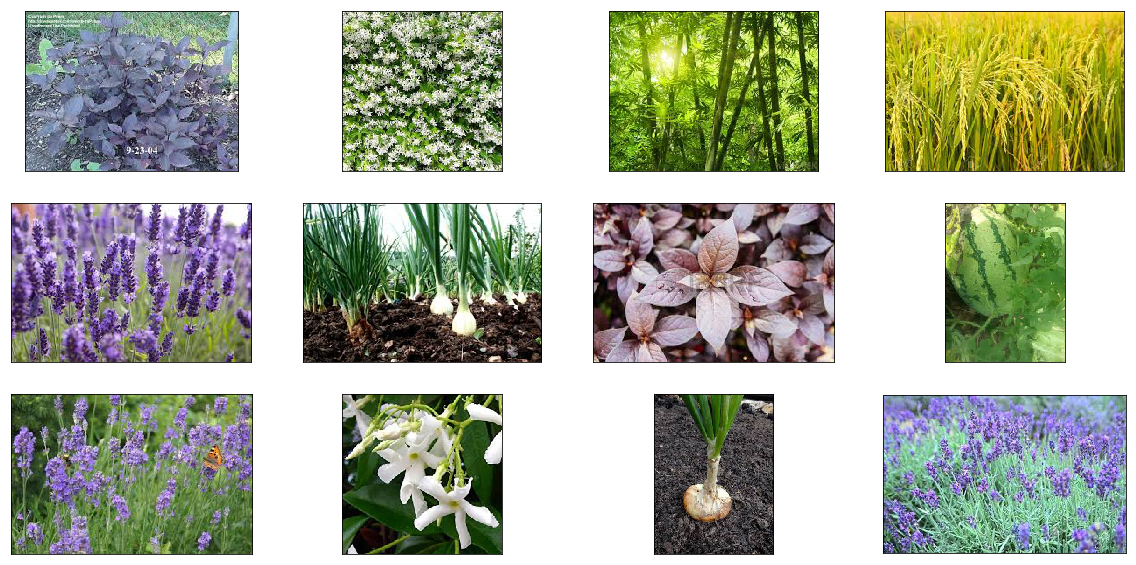

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Plants (from Scratch)

Now that we have functions for detecting humans and plants in images, we need a way to predict breed from images.  In this step, I will create a CNN that classifies plants from scratch. In Step 5 of this notebook, I will use transfer learning to create a CNN that attains greatly improved accuracy.

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 10/10 [00:00<00:00, 321.51it/s]


## Image Augmentation

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)


## Define my own architecture

In [6]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 32)        128       
__________

### Compile the Model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

We train our model in the code cell below.  Notice that I am using model checkpointing to save the model that attains the best validation loss.

In [1]:
epochs = 10
batch_size = 20
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

### Using Image Augmentation
model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=2)

Using TensorFlow backend.


NameError: name 'model' is not defined

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('weights.bestaugmented.from_scratch.hdf5')

### Test the Model

Let's try out our model on the test dataset of plant images. This will be our "test accuracy". 

In [ ]:
# get index of predicted plant for each image in test set
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(test_targets, axis=1))/len(plant_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### More Training
We can resume training to see if accuracy improves

In [ ]:
batch_size = 20
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

In [ ]:
batch_size = 20
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

In [ ]:
batch_size = 64
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

## Test the Model Again
After we test the model again we see that we improved test accuracy up to 51%

In [ ]:
# get index of predicted plant for each image in test set
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(test_targets, axis=1))/len(plant_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)